In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import graphviz

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, Image

%matplotlib inline

In [7]:
%%html 
<style>
table {float:left; border-style: solid;}
</style>

#### Data Description:

| Feature     | Definition                                 | Key                                                                                                                                           |   |   |   |
|:-------------|:--------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------|---|---|---|
| PassengerId | Passenger ID                               |                                                                                                                                               |   |   |   |
| Survival    | Survival - target                          | 0 = No, 1 = Yes                                                                                                                               |   |   |   |
| Pclass      | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                                                                                                                     |   |   |   |
| Name        | Passenger name                             |                                                                                                                                               |   |   |   |
| Sex         | Gender                                     |                                                                                                                                               |   |   |   |
| Age         | Age in years                               | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5                                                          |   |   |   |
| SibSp       | # of siblings / spouses aboard             | Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife (mistresses and fiancés were ignored)                               |   |   |   |
| Parch       | # of parents / children aboard the Titanic | Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them. |   |   |   |
| Ticket      | Ticket number                              |                                                                                                                                               |   |   |   |
| Fare        | Passenger fare                             |                                                                                                                                               |   |   |   |
| Cabin       | Cabin number                               |                                                                                                                                               |   |   |   |
| Embarked    | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton                                                                                                |   |   |

In [8]:
# importing the dataset
data_path = 'data/'
file_name = 'titanic_train.csv'
titanic_df = pd.read_csv(data_path+file_name)
display(titanic_df.shape)
titanic_df.info()
titanic_df.head()

(891, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# % of missing values
pd.DataFrame(np.round(titanic_df.isna().sum()/len(titanic_df)*100,2), columns=['% Missing'])

# Observations:
# - Age has 177 missing values (~19.87%)
# - Cabin has only 204 non-null values, meaning that only ~22.9% of the instances have values for this feature.
# - There are 2 missing values for Embarked (0.22%).

,% Missing
PassengerId,0.00
Survived,0.00
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00


In [10]:
# Examining/handling features with missing values

# 1. Cabin has a large number of missing values. These are my observations w.r.t. this feature:
    # - I did some research and found that the source of information of the allocation of cabins on the Titanic comes from incomplete lists, a few boarding passes and recollections from survivors (https://www.encyclopedia-titanica.org/cabins.html).
    # - I don't think there is much to do with this feature. The high ratio of missing values and the inherent uncertainty in the data makes it difficult to extract accurate data regarding the decks priority, for example. Mapping this feature to a 'Has_Cabin' binary feature might not be a good idea either; after all, this would only represent missing and non-missing values. 
    # - On top of that, it would be reasonable to conclude that the passengers class is highly correlated to the cabin allocation. Hence, the predictive power of Cabin might not be significant if Pclass and maybe Fare are included in the model.
    # - I will drop 'Cabin' from the data set.
    
display(titanic_df[titanic_df.Cabin.notnull()]['Pclass'].value_counts())
display(titanic_df.Pclass.value_counts())

1    176
2     16
3     12
Name: Pclass, dtype: int64

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
# 2. Embarked has only 2 missing values. These can be imputed using the mode of the feature.
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df.Embarked.mode()[0])
titanic_df['Embarked'].isna().sum()

0

In [12]:
# 3. Age is missing 19.87% of its values. These values can be imputed; however, imputing with the mean age is not suitable right now, I might end up assigning 'odd' values. 
# - Instead, I will impute these missing values using the mean age of certain groups. These groups will be based on the title, or salutation, extracted from the name of the passengers.
# - The assumption here is that the average age of unmarried women, for example, should be lower than married ones. Similarly, certain salutations or the lack of one might indicate younger people (teenagers).
# - Therefore, I will first work on 'Name' to extract the salutations and will go back to 'Age' to handle the missing values.

# extracting salutation/title from 'Name' using regex (combination of letters followed by a dot)
titanic_df['Salutation'] = titanic_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_df['Salutation'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Salutation, dtype: int64

About the salutations (https://en.wikipedia.org/wiki/English_honorifics#Common_titles | https://en.wikipedia.org/wiki/Jonkheer):
- Mr: for men, regardless of marital status, who do not have another professional or academic title.
- Miss: for girls, unmarried women and (in the UK) married women who continue to use their maiden name (although "Ms" is often preferred for the last two).
- Mrs: for married women who do not have another professional or academic title, an abbreviation of Mistres.
- Master: for boys and young men. It may also be used as a professional title.
- Dr: Doctor.
- Rev: Reverend.
- Mlle: French equivalent of “Miss”.
- Major: Major, a military rank.
- Col: Colonel, a military rank.
- Countess: Noblewoman.
- Capt: Captain.
- Ms: for women, regardless of marital status or when marital status is unknown.
- Sir: for men, formally if they have a British knighthood or if they are a baronet.
- Lady: for female peers with the rank of baroness, viscountess, countess, and marchioness
- Mme: Madamme. French equivalent to Mrs.
- Don: nobility title for men.
- Jonkheer: honorific in the Low Countries denoting the lowest rank within the nobility.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

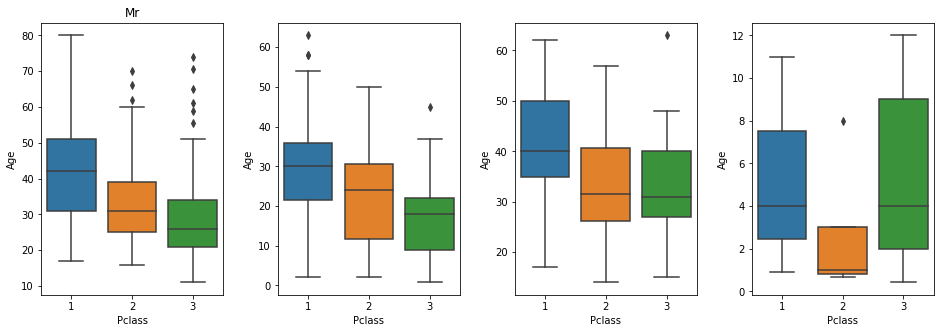

In [13]:
# - I could group titles that might be considered as 'synonyms' to reduce the cardinality and find appropriate groups to then impute Age. This is the mapping I will use:
    # - Mr: Mr, Dr, Rev, Major, Col, Capt, Sir, Don, Jonkheer
    # - Miss (unmarried): Miss, Mlle
    # - Mrs: Mrs, Lady, Mme, Countess, Ms
    # - Master
    
# defining groups
grp_mr = ['Mr', 'Dr', 'Rev', 'Major', 'Col', 'Capt', 'Sir', 'Don', 'Jonkheer'] # adult men
grp_mss =['Miss', 'Mlle'] # young girls and/or unmarried women
grp_mrs = ['Mrs', 'Lady', 'Mme', 'Countess', 'Ms'] # married women
grp_mstr = ['Master'] # young boys

# before imputing, let's see if Pclass is correlated the mean Age
fig, ax = plt.subplots(1,4, figsize=(16,5), gridspec_kw={'hspace': 0.3, 'wspace':0.3})
sns.boxplot(data=titanic_df[titanic_df.Salutation.isin(grp_mr)], y='Age', x='Pclass',  ax=ax[0]).set_title('Mr')
sns.boxplot(data=titanic_df[titanic_df.Salutation.isin(grp_mss)], y='Age', x='Pclass',  ax=ax[1])
sns.boxplot(data=titanic_df[titanic_df.Salutation.isin(grp_mrs)], y='Age', x='Pclass',  ax=ax[2])
sns.boxplot(data=titanic_df[titanic_df.Salutation.isin(grp_mstr)], y='Age', x='Pclass',  ax=ax[3])

In [14]:
# - The range of Age per Salutation varies with Pclass, I will use both to impute missing values in Age

titanic_df['Age'] = titanic_df.Age.fillna(round(titanic_df[titanic_df.Salutation.isin(grp_mr)].groupby('Pclass')['Age'].transform('mean')))

titanic_df['Age'] = titanic_df.Age.fillna(round(titanic_df[titanic_df.Salutation.isin(grp_mss)].groupby('Pclass')['Age'].transform('mean')))

titanic_df['Age'] = titanic_df.Age.fillna(round(titanic_df[titanic_df.Salutation.isin(grp_mrs)].groupby('Pclass')['Age'].transform('mean')))

titanic_df['Age'] = titanic_df.Age.fillna(round(titanic_df[titanic_df.Salutation.isin(grp_mstr)].groupby('Pclass')['Age'].transform('mean')))

# checking missing values
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Salutation       0
dtype: int64

#### Feature Engineering

In [15]:
# Family size: the assumption is that passengers travelling with family might have prioritized their lives over their own. It would be interesting to analyze if passengers travelling alone did better.
titanic_df['FamilySize'] = titanic_df.SibSp + titanic_df.Parch
titanic_df['FamilySize'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64

In [16]:
# Salutation was used for imputing missing values in Age, but it might also provide details about social ranking.

# - Initially, I considered creating a new feature to represent whether the passenger has a nobility title or not. However, there is only one instance for each of the nobility titles in the data ('Countess', 'Lady', 'Sir', 'Don', 'Jonkheer')—5 instances, 3 Survived =1, 2 Survived=0. I am discarding the idea.

nob_titles = ['Countess', 'Lady', 'Sir', 'Don', 'Jonkheer']
titanic_df[titanic_df.Salutation.isin(nob_titles)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Salutation,FamilySize
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,Don,0
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,Lady,1
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,Sir,1
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S,Countess,0
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,Jonkheer,0


In [17]:
# - Also, there are salutations/titles that, even when they are not considered 'noble' per se, they involve a higher social ranking. For example, Colonel, Reverend, Major, etc.
# - It is worth mentioning that salutations/titles usually imply the gender.
# - Let's try to reduce the cardinality of this new feature and analyze it.

titanic_df.Salutation.replace(['Mlle','Mme','Ms'], ['Miss','Mrs','Mrs'], inplace=True)


titles = titanic_df.Salutation.unique()
for t in titles:
    print(t)
    display(titanic_df[titanic_df.Salutation == t]['Sex'].value_counts())

Mr


male    517
Name: Sex, dtype: int64

Mrs


female    127
Name: Sex, dtype: int64

Miss


female    184
Name: Sex, dtype: int64

Master


male    40
Name: Sex, dtype: int64

Don


male    1
Name: Sex, dtype: int64

Rev


male    6
Name: Sex, dtype: int64

Dr


male      6
female    1
Name: Sex, dtype: int64

Major


male    2
Name: Sex, dtype: int64

Lady


female    1
Name: Sex, dtype: int64

Sir


male    1
Name: Sex, dtype: int64

Col


male    2
Name: Sex, dtype: int64

Capt


male    1
Name: Sex, dtype: int64

Countess


female    1
Name: Sex, dtype: int64

Jonkheer


male    1
Name: Sex, dtype: int64

In [18]:
# almost every salutation refers to a specific Sex level (gender); the exception being Dr, for this title there is one instance with Sex=Female.
# Let's update the salutation for that instance from Dr to Dra to differentiate it and continue reducing the cardinality of this feature.
# The idea is to define the following levels:
    # - Miss: young girls, unmarried woman
    # - Mrs: married woman
    # - Master: young boys
    # - Mr: men
    # - Other_F: women with these somewhat 'unusual' titles such as Lady, Countess, etc.
    # - Other_M: men with these somewhat 'unusual' titles such as Sir, Don, Col, Rev, etc.
# Once done this, we could say that 'Salutation' would be a feature providing info about social ranking and also gender; therefore, 'Sex' could be dropped since it's implied in the salutation/title, I will analyze this idea when I plot the correlation matrix.

titanic_df.loc[(titanic_df.Sex == 'female') & (titanic_df.Salutation == 'Dr'),'Salutation'] = 'Dra'
titanic_df.Salutation.value_counts()               

Mr          517
Miss        184
Mrs         127
Master       40
Rev           6
Dr            6
Major         2
Col           2
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Dra           1
Jonkheer      1
Name: Salutation, dtype: int64

In [19]:
# reducing cardinality by grouping salutations
titanic_df.Salutation.replace(['Dr','Major','Jonkheer', 'Col','Rev','Capt','Sir','Don', 'Lady','Countess', 'Dra'], ['Other_M','Other_M','Other_M', 'Other_M','Other_M','Other_M', 'Other_M','Other_M', 'Other_F', 'Other_F', 'Other_F'], inplace=True)
titanic_df.Salutation.value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Other_M     20
Other_F      3
Name: Salutation, dtype: int64

In [20]:
# dataframe up to this point
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Salutation   891 non-null    object 
 13  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


#### EDA and more feature engineering

In [21]:
# numeric features
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.462593,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,13.556455,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,36.750000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [22]:
# 'object' features
titanic_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Salutation
count,891,891,891,204,891,891
unique,891,2,681,147,3,6
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S,Mr
freq,1,577,7,4,646,517


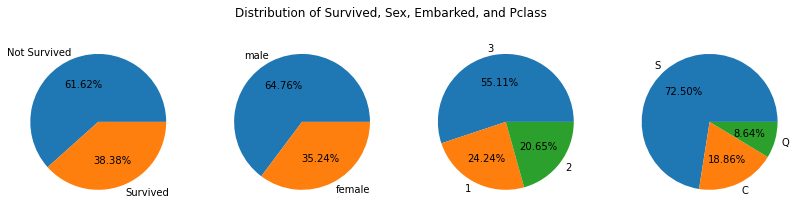

In [23]:
fig, ax = plt.subplots(1,4, figsize=(14,6))
# survived
titanic_df.Survived.value_counts().plot.pie(labels=["Not Survived", "Survived"], autopct='%.2f%%', ylabel='', ax=ax[0])
# sex
titanic_df.Sex.value_counts().plot.pie(autopct='%.2f%%', ylabel='', ax=ax[1])
# pclass
titanic_df.Pclass.value_counts().plot.pie(autopct='%.2f%%', ylabel='', ax=ax[2])
# embarked
titanic_df.Embarked.value_counts().plot.pie(autopct='%.2f%%', ylabel='', ax=ax[3])

fig.suptitle('Distribution of Survived, Sex, Embarked, and Pclass')
fig.subplots_adjust(top=1.3)
plt.show()

Sadly, over 60% of people did not survive. There were more men than women aboard the Titanic, around 65%. Second class was the least represented with ~21% while third class accounted for ~55%. The majority of people embarked in the Southampton port.

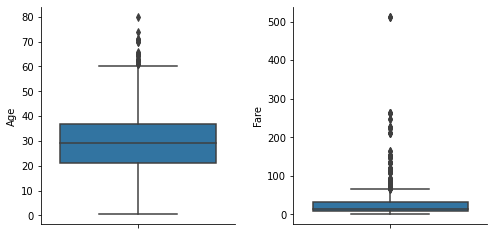

In [24]:
fig, ax = plt.subplots(1,2, figsize=(8,4), gridspec_kw={'wspace':0.3})
# age
sns.boxplot(data = titanic_df, y='Age', ax=ax[0])
# fare
sns.boxplot(data = titanic_df, y='Fare', ax=ax[1])
sns.despine()
plt.show()

The majority of passengers were less than 40 years old, but some were up to 80. Fare is mainly less than 100 except for a few outliers that go as high as 500+.

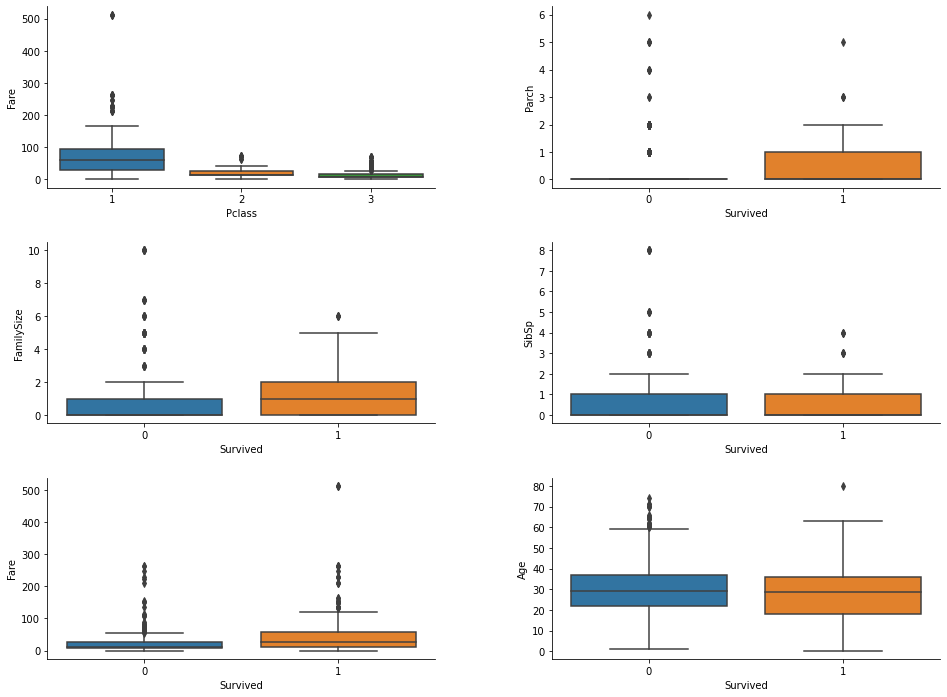

In [25]:
fig, ax = plt.subplots(3,2, figsize=(16,12), gridspec_kw={'hspace': 0.3, 'wspace':0.3})
# age
sns.boxplot(data = titanic_df, x='Pclass', y='Fare', ax=ax[0][0])
# fare
sns.boxplot(data = titanic_df, x='Survived', y='Parch',  ax=ax[0][1])
# family size
sns.boxplot(data = titanic_df, x='Survived', y='FamilySize', ax=ax[1][0])
# sibsp
sns.boxplot(data = titanic_df, x='Survived', y='SibSp', ax=ax[1][1])
# parch
sns.boxplot(data = titanic_df, x='Survived', y='Fare', ax=ax[2][0])
# age boxplot
sns.boxplot(data = titanic_df, x='Survived', y='Age', ax=ax[2][1])

sns.despine()
plt.show()

- As expected, first class passengers' fare covers the highest range.
- SibSp does not seem to quite impact the target. Neither does Age. Parch, on the other hand, has higher correlation to the target compare to the SibSp and Age.
- Passengers who paid a higher fare had greater chance to survive, which matches 1st class passengers.

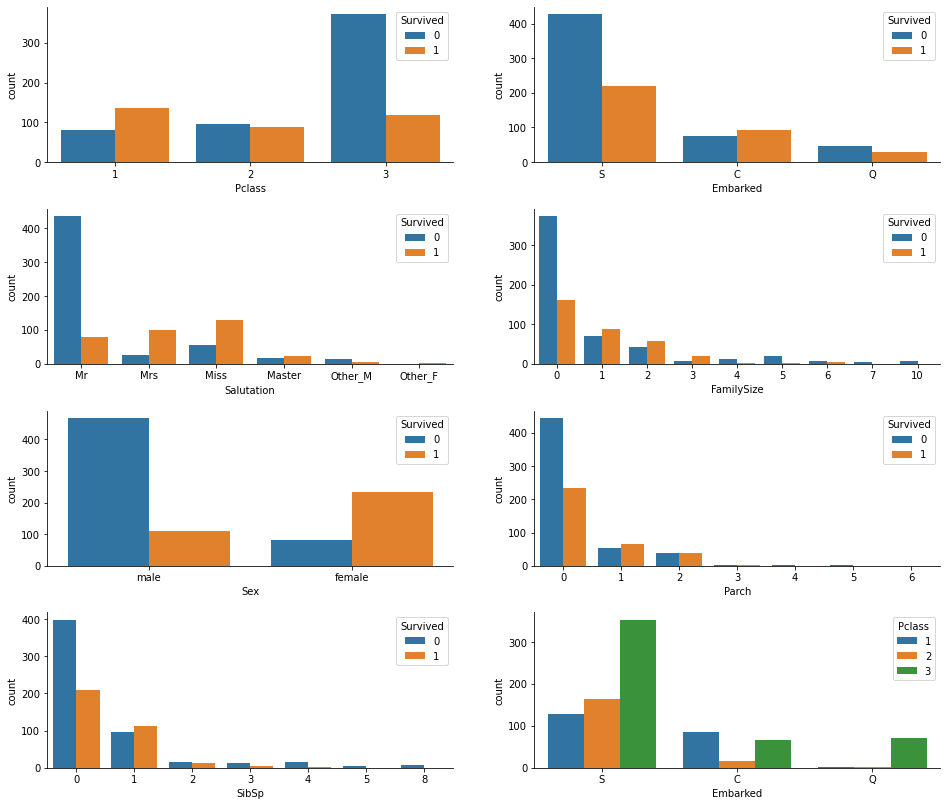

In [26]:
fig, axes = plt.subplots(4,2, figsize=(16,14), gridspec_kw={'hspace': 0.3})
# pclass
sns.countplot(data=titanic_df, x="Pclass", hue="Survived", ax= axes[0][0])
# embarked
sns.countplot(data=titanic_df, x="Embarked", hue="Survived", ax= axes[0][1])
# salutation
sns.countplot(data=titanic_df, x="Salutation", hue="Survived", ax= axes[1][0])
axes[1][0].legend(loc='upper right', title='Survived')
# family size
sns.countplot(data=titanic_df, x="FamilySize", hue="Survived", ax= axes[1][1])
axes[1][1].legend(loc='upper right', title='Survived')
# sex
sns.countplot(data=titanic_df, x="Sex", hue="Survived", ax= axes[2][0])
# parch
sns.countplot(data=titanic_df, x="Parch", hue="Survived", ax= axes[2][1])
axes[2][1].legend(loc='upper right', title='Survived')
# sibsp
sns.countplot(data=titanic_df, x="SibSp", hue="Survived", ax= axes[3][0])
axes[3][0].legend(loc='upper right', title='Survived')
# embarked vs pclass
sns.countplot(data=titanic_df, x="Embarked", hue="Pclass", ax= axes[3][1])

sns.despine()
plt.show()

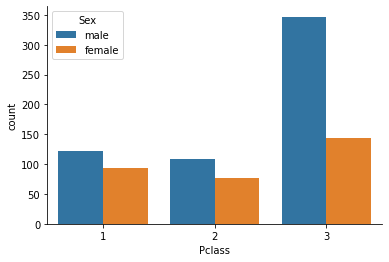

In [27]:
sns.countplot(data=titanic_df, x="Pclass", hue="Sex")
sns.despine()
plt.show()

In [28]:
display(pd.crosstab(titanic_df.Survived, titanic_df.FamilySize, normalize='columns'))
display(pd.crosstab(titanic_df.Sex, titanic_df.FamilySize, normalize='columns'))
display(pd.crosstab(titanic_df.Pclass, titanic_df.FamilySize, normalize='columns'))

FamilySize,0,1,2,3,4,5,6,7,10
Survived,,,,,,,,,
0,0.696462,0.447205,0.421569,0.275862,0.8,0.863636,0.666667,1.0,1.0
1,0.303538,0.552795,0.578431,0.724138,0.2,0.136364,0.333333,0.0,0.0


FamilySize,0,1,2,3,4,5,6,7,10
Sex,,,,,,,,,
female,0.234637,0.540373,0.480392,0.655172,0.8,0.363636,0.666667,0.333333,0.428571
male,0.765363,0.459627,0.519608,0.344828,0.2,0.636364,0.333333,0.666667,0.571429


FamilySize,0,1,2,3,4,5,6,7,10
Pclass,,,,,,,,,
1,0.202980,0.434783,0.235294,0.241379,0.133333,0.181818,0.0,0.0,0.0
2,0.193669,0.211180,0.303922,0.448276,0.066667,0.045455,0.0,0.0,0.0
3,0.603352,0.354037,0.460784,0.310345,0.800000,0.772727,1.0,1.0,1.0


- First class passengers had greater chance of survival, around 60%. Third class passengers had less than 40% chance of survival.
- Women were significantly more likely to survive than men.
- Chances of survival are higher for passengers who embarked at port C. However, this is correlated to Pclass, since port C, compared to S and Q, is the only one where more 1st class passengers embarked compared to class 2 and 3.
- Regarding Salutation, women-related titles had a better chance of survival, but again, this is because females overall had a higher probability of survival.
- FamilySize is the result of combining SibSp and Parch. About this feature: 
    - People who travelled alone had around 30% chance of surviving, but most people travelling alone were men (~77%) and/or 3rd class passengers. 
    - People whose family on the Titanic was 1-3 had better chances of survival but this seems to be related to Sex and Pclass. On those groups, women accounted for a significant proportion and/or they were mostly 1st and 2nd class passengers.

Now, let's take a look at Age and Fare. It was already noticed that there are outliers for these features.

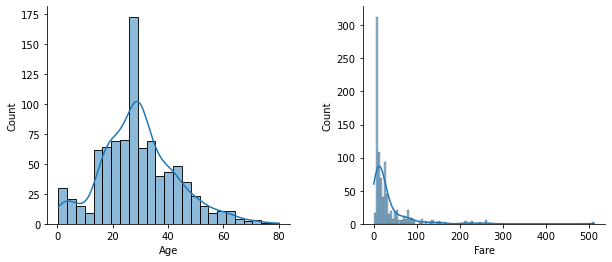

In [29]:
fig, ax = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'wspace':0.3})
sns.histplot(data=titanic_df, x='Age', kde=True, ax=ax[0])
sns.histplot(data=titanic_df, x='Fare', kde=True, ax=ax[1])
sns.despine()
plt.show()

Age and Fare follow skewed distributions with multiple outliers at higher values. These 'unusual' high values are however valid. While the minority of passengers were 60+ years old, having a few being as old as 80 is completely valid. Similarly, while most passenger paid less than 100, having Fare values that reach up to 513 would be valid, and even expected since 1st and 2nd class passengers are the majority and they would have paid more than 3rd class passengers.

To handle the features' outliers, to facilitate analysis, and to later reduce the trees splits, I will use bucketing to determine categories, or bands, for Age and Fare. In the case of Fare, for example, I decide not to use clip (clamp transfformation) because the outliers provide meaningful information, they correspond to 1st class passenger who also have greater chances of surviving according to the data.

In [30]:
# fare
# quantile bucketing
fare_band = pd.qcut(titanic_df.Fare, 4)
fare_band.value_counts()

(7.91, 14.454]     224
(-0.001, 7.91]     223
(14.454, 31.0]     222
(31.0, 512.329]    222
Name: Fare, dtype: int64

,FareBand,Survived
3,"(31.0, 512.329]",0.581081
2,"(14.454, 31.0]",0.454955
1,"(7.91, 14.454]",0.303571
0,"(-0.001, 7.91]",0.197309


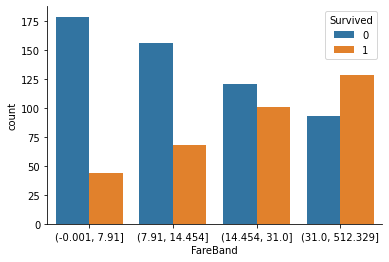

In [31]:
titanic_df['FareBand'] = fare_band
# % survived per fare band
display(titanic_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='Survived', ascending=False))

sns.countplot(data=titanic_df, x="FareBand", hue="Survived")
sns.despine()
plt.show()

It seems that the chances of surviving increase as the fare band increases, which matches what was already known: most expensive tickets correspond to higher class (Pclass).

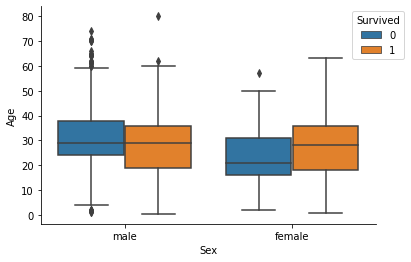

In [32]:
#age
fig, ax = plt.subplots()
sns.boxplot(data = titanic_df, x='Sex', y='Age', hue='Survived', ax=ax)
ax.legend(loc='upper right', title='Survived', bbox_to_anchor=(1.1, 1))
sns.despine()
plt.show()

In [33]:
age_band = pd.qcut(titanic_df.Age, 4)
age_band.value_counts()

# buckets of different size because there are values thay may fit multiple bands

(21.0, 29.0]     272
(0.419, 21.0]    241
(36.75, 80.0]    223
(29.0, 36.75]    155
Name: Age, dtype: int64

,AgeBand,Survived
2,"(29.0, 36.75]",0.458065
0,"(0.419, 21.0]",0.448133
3,"(36.75, 80.0]",0.381166
1,"(21.0, 29.0]",0.286765


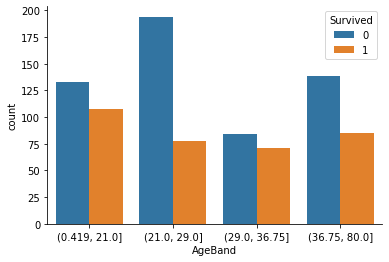

In [34]:
titanic_df['AgeBand'] = age_band
# % survived per age band
display(titanic_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='Survived', ascending=False))

sns.countplot(data=titanic_df, x="AgeBand", hue="Survived")
sns.despine()
plt.show()

A strict pattern is not quite clear when it comes to Age, but for sure the chance of survival for younger people ((0.419, 22.0]) is the highest.

,FSizeBand,Survived
3,small,0.578767
0,alone,0.303538
2,medium,0.204082
1,large,0.000000


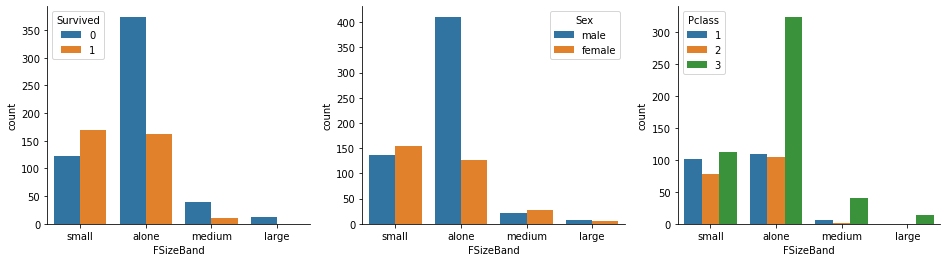

In [35]:
# family size: current cardinality is 9, let's try to group into categories
# pandas.qcut is not suitable in this case because around 60% of the values fall in the same category/band (family sizee=0). 
# Instead, I will create the categories manually because I also think that people who travelled aloned should have their own band.

fam_size_map = {0: 'alone', 1: 'small', 2: 'small', 3: 'small', 4: 'medium', 5: 'medium', 6: 'medium', 7: 'large', 10: 'large'}
titanic_df['FSizeBand'] = titanic_df['FamilySize'].map(fam_size_map)

# % survived per familiy cat
display(titanic_df[['FSizeBand', 'Survived']].groupby(['FSizeBand'], as_index=False).mean().sort_values(by='Survived', ascending=False))

fig, ax = plt.subplots(1,3, figsize=(16,4))
sns.countplot(data=titanic_df, x="FSizeBand", hue="Survived", ax=ax[0])
sns.countplot(data=titanic_df, x="FSizeBand", hue="Sex", ax=ax[1])
sns.countplot(data=titanic_df, x="FSizeBand", hue="Pclass", ax=ax[2])
sns.despine()
plt.show()

When the family size is *small*, chances of surviving increase; it's also noticed that in this category women and 1st class passengers account for the majority. Surviving odds for passengers with a large family is the lowest at 0%.